# 1-Choose the right distance cutoffs 

In this notebook, we introduce the concept of dual-cutoff for, eps. coarse-grained simulations, and how to determine the two cutoff values for PyLipID. In this dual-cutoff scheme, a contact starts when any atom/bead of a molecule moves closer to the target than the lower cutoff, and ends when all of the atom/bead moves farther than the upper cutoff. The duration between the start and end points is considered as the duration of a continuous contact. 

PyLipID uses this dual-cutoff scheme to deal with the 'rattling in the cage' effect in coarse-grained simulations, in which the coarse-grained beads, due to the smoothened potentials, could have large jigglings around their positions. Thus the choice of the cutoff values will affect the accuracy of PyLipID calculation. 

We will first illustrate the 'rattling in cage' effect, then look at ways to determine the optimal dual cutoffs for a system. We will also have a brief look at how the choice of cutoff values affects binding site calculation. Finally we will test the dual-cutoff on atomistic simulations. We recommend users to test on cutoffs when applying PyLipID to a new system, esp. to different types of lipid. 

PyLipID also accepts using the usual single cutoff scheme. Users only need to provide a single cutoff value to shift to the single cutoff. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylipid
from pylipid.api import LipidInteraction

## The "rattling in cage" effect in MARTINI force field

MARTINI force field often generates large jigglings of beads, with deviations from their positions as large as 0.4 nm. As these deviations would come back very quick, they should not be considered as dissociations. To check on these jigglings, we can plot the minimum distances of protein residues to their contacting lipid molecules. 

Here we still use the simulation trajectories of Adenosine 2a receptor (A2aR) that was used in the previous 'walk-through' tutorial. In these trajectories, a single copy of A2aR was embedded in a complex membrane containing 7 lipid species, including PC, PE, PS, PIP2, CHOL, GM3, Sph (See figure 1 in the previous tutorial). Let's use the following script to look at the minimum distances of the contacting cholesterol molecules with protein residues. 

In [2]:
from itertools import product
import mdtraj as md
from pylipid.utils import get_traj_info, check_dir

def plot_minimum_distances(distances, times, title, fn):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.plot(times, distances)
    ax.set_xlabel(r"Time ($\mu$s)")
    ax.set_ylabel("Minimum distances (nm)")
    ax.set_title(title)
    ax.set_ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    plt.close()
    return


def compute_contact_distance(traj, lipid, fig_dir, lipid_atoms=None, 
                            contact_frames=10, distance_threshold=0.65):
    DIST_CONTACT_ALL = []
    traj_info, _, _ = get_traj_info(traj, lipid, lipid_atoms=lipid_atoms)
    for protein_idx in np.arange(nprot, dtype=int):
        for residue_idx, residue_atom_indices in enumerate(
            traj_info["protein_residue_atomid_list"][protein_idx]):
            dist_matrix = np.array([np.min(
                            md.compute_distances(traj, np.array(list(product(residue_atom_indices, lipid_atom_indices)))),
                            axis=1) for lipid_atom_indices in traj_info["lipid_residue_atomid_list"]])
            # plot distances
            for lipid_idx in np.arange(len(dist_matrix)):
                if sum(dist_matrix[lipid_idx] < distance_threshold) >= contact_frames:
                    DIST_CONTACT_ALL.append(dist_matrix[lipid_idx])
                    plot_minimum_distances(dist_matrix[lipid_idx], traj.time/1000000.0, 
                                           "{}-{}{}".format(traj_info["residue_list"][residue_idx], lipid, lipid_idx), 
                                           "{}/dist_{}_{}{}.png".format(fig_dir, traj_info["residue_list"][residue_idx], 
                                                                        lipid, lipid_idx))
    
    return DIST_CONTACT_ALL


trajfile = "./traj_data/A2a/run1/protein_lipids.xtc"
topfile = "./traj_data/A2a/run1/protein_lipids.gro"
lipid = "CHOL"
lipid_atoms = None # all lipid atom/bead will be considered
nprot = 1
save_dir = "test_minimum_dist_A2a_{}".format(lipid)
fig_dir = check_dir(save_dir, "Figures", print_info=False)
contact_frames = 30  # will only plot data if the contact was formed over ${contact_frames} frames.
distance_threshold = 0.65

traj = md.load(trajfile, top=topfile)
cotanct_distance_set = compute_contact_distance(traj, lipid, fig_dir, lipid_atoms=lipid_atoms,
                                               contact_frames=10, distance_threshold=0.65)


In this script, we plotted the minimum distances of a cholesterol molecule to a protein residue if their minimum distance stayed below 0.65nm (controled by `distance_threshold`) over 10 frames (controled by `contact_frames`). We made these two parameters of `distance_threshold` and `contact_frames` in the script to screen out the noises, otherwise it could have generate loads of figures. 

We can check the generated figures and find different contact activities. For example, we can find some contacts with small jigglings, in which cases the minimum distances stayed around 0.475 nm: 

<img src="statics/dist_9THR_CHOL224.png" />

and some with larger jigglings, in which cases the minimum distances can shift to 0.7-0.8 nm:

<img src="statics/dist_10VAL_CHOL6.png" />

For some messier situations, we can find that lipids came close to the target without forming an effective contact, in which cases the minimum distances still can reach as low as 0.65-0.7 nm: 

<img src="statics/dist_27TRP_CHOL166.png" />

**Therefore, we want to use the lower cutoff of the dual-cutoff scheme to pick out the effective contacts and use the upper one to deal with the jigglings.**

We can also look at the distribution of the minimum distances: 

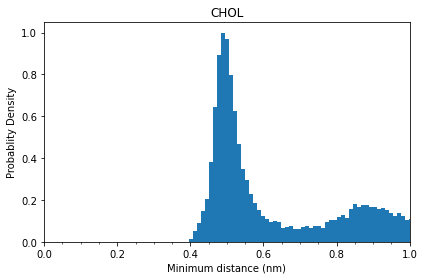

In [3]:
import matplotlib.ticker as ticker

def plot_PDF(distance_set, num_of_bins, fn):
    fig, ax = plt.subplots(1,1)
    ax.hist(distance_set, bins=num_of_bins, density=True)
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("Minimum distance (nm)")
    ax.set_ylabel("Probablity Density")
    ax.set_title(lipid)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    return

distance_set = np.concatenate(cotanct_distance_set)
num_of_bins = 1000
fig_fn = "{}/dist_distribut_{}.png".format(save_dir, lipid)
plot_PDF(distance_set, num_of_bins, fig_fn)

From this probability distribution plot, we can see that the first contact layer of cholesterol starts at ~ 0.4 nm, peaks at ~0.5 nm and ends at ~0.7 nm. 

Let's check the contact activities of some phospholipids. In this case, we chose to look at PIP2 molecules, the residue name of which is "POP2" in MARTINI force field. PIP2 lipids have been shown to bind to a couple of GPCRs and exert allosteric modulation on the receptor functions. Let's use the functions defined above to plot minimum distances of PIP2 with A2aR. Considering the lipid acyl tails are often too dynamic, we decided to only include the lipid headgroup beads for calculation, to produce better defined binding events. Thus, we provide to the `lipid_atoms` a list of atom names of PIP2 headgroup beads. 

In [4]:
trajfile = "./traj_data/A2a/run1/protein_lipids.xtc"
topfile = "./traj_data/A2a/run1/protein_lipids.gro"
lipid = "POP2" # residue name of PIP2
lipid_atoms = ["C1", "C2", "C3", "PO4", "P1", "P2"] # PIP2 headgroup beads
nprot = 1
save_dir = "test_minimum_dist_A2a_{}".format(lipid)
fig_dir = check_dir(save_dir, "Figures", print_info=False)
contact_frames = 10  # will only plot data if the contact was formed over ${contact_frames} frames.
distance_threshold = 0.65

traj = md.load(trajfile, top=topfile)
cotanct_distance_set = compute_contact_distance(traj, lipid, fig_dir, lipid_atoms=lipid_atoms,
                                               contact_frames=10, distance_threshold=0.65)

Similar to what we have seen from cholesterol bindings, we can find some interactions with small jigglings:

<img src="statics/dist_203ARG_POP229.png" />

and some with larger jigglings: 

<img src="statics/dist_120LYS_POP211.png" />

We can even find that the bindings of PIP2 are more stable, i.e. the durations of the bindings are longer. One PIP2 molecule bound to A2aR without dissociation in the 3 micro-second simulation:

<img src="statics/dist_197ARG_POP218.png" />

Let's check the distribution of PIP2 minimum distances:

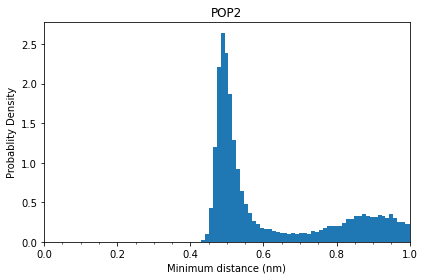

In [5]:
distance_set = np.concatenate(cotanct_distance_set)
num_of_bins = 1000
fig_fn = "{}/dist_distribut_{}.png".format(save_dir, lipid)
plot_PDF(distance_set, num_of_bins, fig_fn)

Comparing to that of cholesterols, the distance distribution of PIP2 has a narrower first peak, which starts at ~0.425 nm and ends at ~0.675 nm. 

## Determining the cutoff values

As we have shown above, the binding activities of cholesterol and PIP2 are different, when they bind to the same receptor A2aR. The situation could be more complex if we compare the binding activities of lipids to different receptors. We therefore need to do a systematic check on the suitable cutoffs whenever we apply PyLipID to different systems and different lipids. 

To illustrate that the contact distances could be different with different proteins, we include testings of cutoffs on two systems: one on a Class A GPCR, A2aR and the other on the ligand-gated ion channel GABAA. Each receptor had two simulation repeats. 

We start by checking the impact of different cutoffs on a couple of contact metrics, including num. of binding sites, num. of contacting residues, and the average interaction durations. By plotting these metrics as a function of different cutoffs, we will try to find the cutoffs that optimize the calculation of contacts and binding sites. 

Let's first define a test function:

In [6]:
from itertools import product
import shutil

def test_cutoffs(cutoff_list, trajfile_list, topfile_list, lipid, lipid_atons, nprot=1,
                 stride=1, save_dir=None, timeunit="us"):
    num_of_binding_sites = []
    duration_avgs = []
    num_of_contacting_residues = []
    for cutoffs in cutoff_list:
        li = LipidInteraction(trajfile_list, topfile_list=topfile_list, cutoffs=cutoffs, lipid=lipid,
                              lipid_atoms=lipid_atoms, nprot=1, timeunit=timeunit, 
                              save_dir=save_dir, stride=stride)
        li.collect_residue_contacts(write_log=False, print_log=False)
        li.compute_binding_nodes(print_data=False) # switch print and write to False for cleaner output.
        num_of_binding_sites.append(len(li.node_list))
        duration_avgs.append(li.dataset["Duration"].mean())
        num_of_contacting_residues.append(sum(li.dataset["Duration"]>0))
    shutil.rmtree(li.save_dir)
    return num_of_binding_sites, duration_avgs, num_of_contacting_residues


lower_cutoff = [0.375, 0.40, 0.425, 0.45, 0.475, 0.5]
upper_cutoff = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
cutoff_list = list(product(lower_cutoff, upper_cutoff))

Here, we used interaction durations instead of interaction residence time to speed up the testing. We defined a couple of lower cutoffs and upper cutoffs to test on. 

### cholesterol interactions with A2a

Let's check how cholesterol contacts and binding sites change with different cutoffs in A2a simulations:

In [7]:
import pickle

stride = 1   # use this to speed up if you have too many frames.
lipid = "CHOL"
lipid_atoms = None
nprot = 1
timeunit = "us"

# A2aR simulations
save_dir = check_dir(suffix="test_cutoffs_A2a", print_info=False)

trajfile_list = ["./traj_data/A2a/run1/protein_lipids.xtc", 
                 "./traj_data/A2a/run2/protein_lipids.xtc"]
topfile_list = ["./traj_data/A2a/run1/protein_lipids.gro", 
                 "./traj_data/A2a/run2/protein_lipids.gro"]
num_of_binding_sites, duration_avgs, num_of_contacting_residues = test_cutoffs(
                                 cutoff_list, trajfile_list, topfile_list, lipid, lipid_atoms, 
                                 nprot=nprot, stride=stride, save_dir=save_dir, timeunit=timeunit)


test_data = {"num_of_binding_sites": num_of_binding_sites,
             "duration_avgs": duration_avgs,
             "num_of_contacting_residues": num_of_contacting_residues,
             "test_cutoff_list": cutoff_list}

with open(f"{save_dir}/test_cutoff_data_{lipid}.pickle", "wb") as f:
    pickle.dump(test_data, f, 2)


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

Creating new director: /Users/lindasong/PyLipID/PyLipID-dev/docs/tutorials/test_cutoffs_A2a/Interaction_CHOL


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES: 100%|██████████| 2/2 [00:50<00:00, 25.05s/it]


Let's use the following function to plot the contact metrics as a function of the cutoff values:

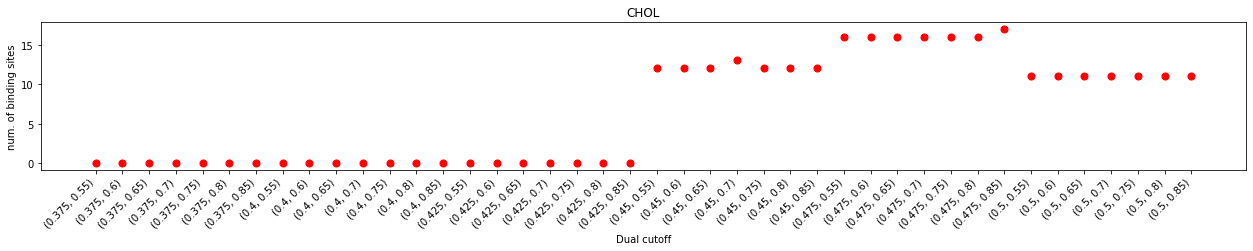

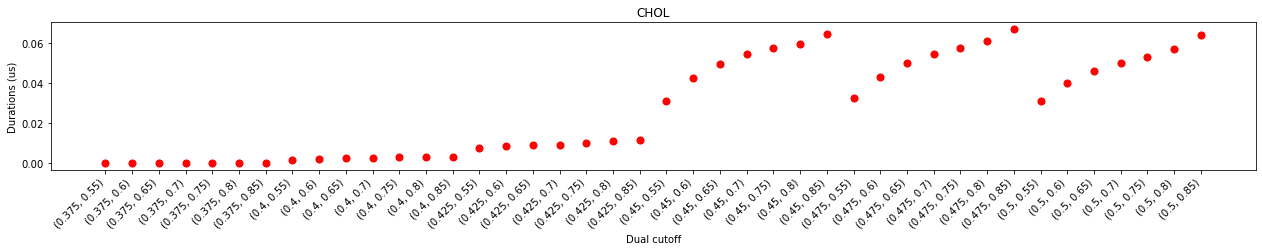

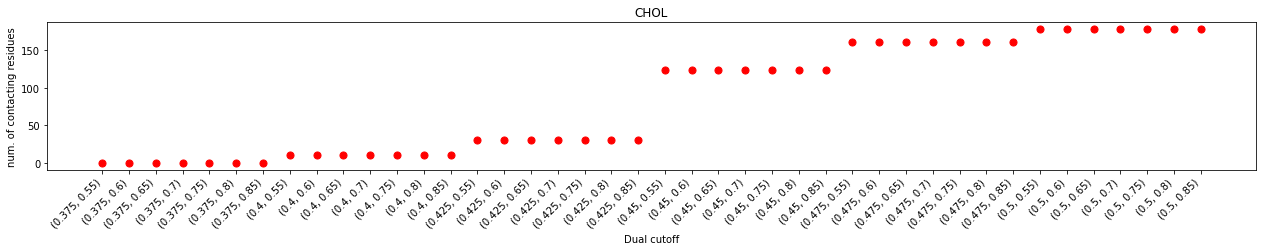

In [8]:
def graph(cutoff_list, metric_values, ylabel, title, fn):
    fig, ax = plt.subplots(1, 1, figsize=(len(cutoff_list)*0.42, 3.6))
    ax.scatter(np.arange(len(cutoff_list)), metric_values, s=50, color='red')
    ax.set_xticks(np.arange(len(cutoff_list)))
    ax.set_xticklabels(cutoff_list, rotation=45, ha='right')
    ax.set_xlabel("Dual cutoff")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    return

graph(cutoff_list, num_of_binding_sites, "num. of binding sites", lipid, 
     f"{save_dir}/test_cutoff_num_of_bs_{lipid}.png")

graph(cutoff_list, duration_avgs, f"Durations ({timeunit})", lipid, 
     f"{save_dir}/test_cutoff_durations_{lipid}.png")

graph(cutoff_list, num_of_contacting_residues, "num. of contacting residues", lipid,
     f"{save_dir}/test_cutoff_num_of_contacting_residues_{lipid}.png")

In the plot of durations and num. of contacting residues, we can see that contacts started to emerge with at the lower cutoff of 0.425 nm but saw a prominent jump at 0.45 nm of the lower cutoff, suggesting that effect contacts start at 0.45 nm. This also agrees with the distribution of the minimum distances which starts 0.4 nm. 

With the same lower cutoff, we saw a positive correlation of the larger upper cutoff and the longer interaction durations. This correlation was almost linear when the upper cutoff is smaller than 0.65 nm, but flattened out after 0.65 nm, suggesting that the impact of increasing the upper cutoff on interaction durations is marginal after this point. Further increase the lower cutoff (data not shown in this test) will see a decrease of interaction durations, regardless of the upper cutoffs, suggesting that too big a lower cutoff will include unnecessary noises which could lead to inaccurate results. 

The impact on binding site calculation was a bit more complex. No effective binding site was detected for lower cutoffs smaller than 0.45 nm, even though some contacts started to emerge at the lower cutoff of 0.425 nm. When the lower cutoff is at 0.45 nm, the binding site calculation was very unstable. The number of detected binding sites flickered with increasing upper cutoffs, suggesting that these dual-cutoffs cannot effectively differentiate binding and unbinding events. The num. of binding sites flattened at the dual cutoff of 0.475-0.7 nm, indicating that this is a good cutoff to effectively separate binding/unbinding activities. 

### PIP2 interactions with A2a

As we have shown above that PIP2 and cholesterols have interaction dynamics with A2a receptor, let's see if interaction metrics would responded differently to the change of cutoffs than those of cholesterols. 

In [9]:
lipid = "POP2"
lipid_atoms = ["C1", "C2", "C3", "PO4", "P1", "P2"]
num_of_binding_sites, duration_avgs, num_of_contacting_residues = test_cutoffs(
                                 cutoff_list, trajfile_list, topfile_list, lipid, lipid_atoms, 
                                 nprot=nprot, stride=stride, save_dir=save_dir, timeunit=timeunit)
test_data = {"num_of_binding_sites": num_of_binding_sites,
             "duration_avgs": duration_avgs,
             "num_of_contacting_residues": num_of_contacting_residues,
             "test_cutoff_list": cutoff_list}

with open(f"{save_dir}/test_cutoff_data_{lipid}.pickle", "wb") as f:
    pickle.dump(test_data, f, 2)

COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

Creating new director: /Users/lindasong/PyLipID/PyLipID-dev/docs/tutorials/test_cutoffs_A2a/Interaction_POP2


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES: 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]


Similar to cholesterol analysis, let's plot the interaction metrics as a function of cutoffs:

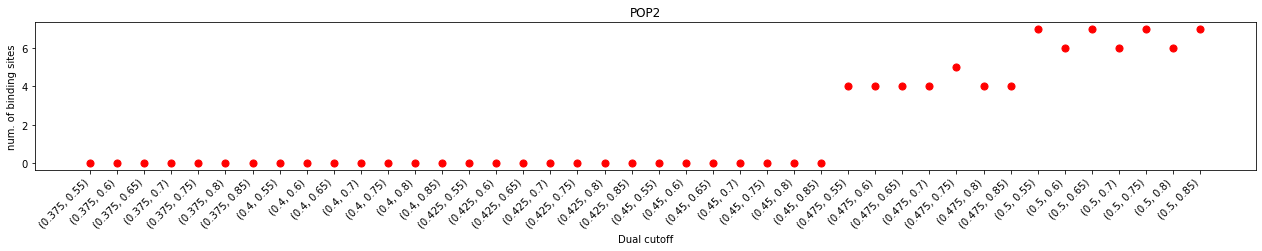

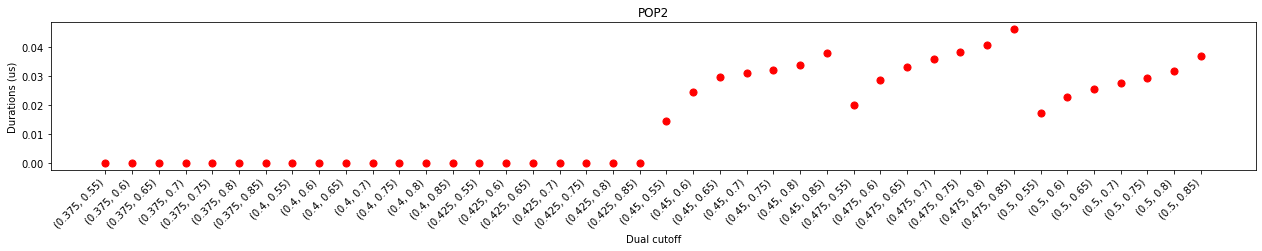

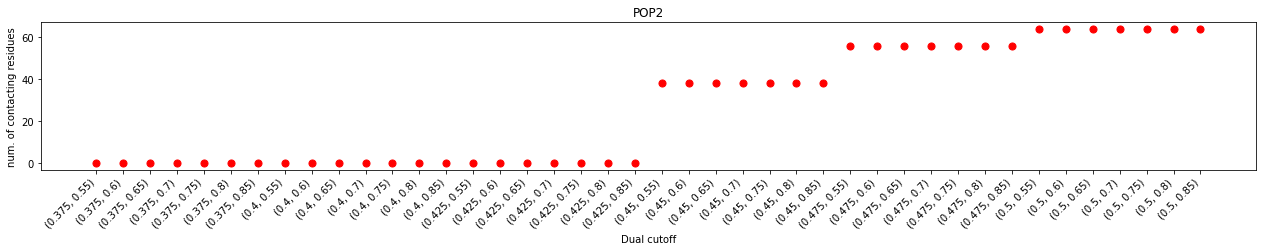

In [10]:
graph(cutoff_list, num_of_binding_sites, "num. of binding sites", lipid, 
     f"{save_dir}/test_cutoff_num_of_bs_{lipid}.png")
graph(cutoff_list, duration_avgs, f"Durations ({timeunit})", lipid, 
     f"{save_dir}/test_cutoff_durations_{lipid}.png")
graph(cutoff_list, num_of_contacting_residues, "num. of contacting residues", lipid,
     f"{save_dir}/test_cutoff_num_of_contacting_residues_{lipid}.png")

One of major differrence, when comparing to cholesterol interactions, is that larger lower cutoffs were required to calculate contacts or binding sites. This observation agreed with the analysis of the minimum distance distribution, which started at 0.425 nm instead of 0.4 nm in that of the cholesterols. Another difference is that the duration plot does not show an obvious plateau as the upper cutoff increased from 0.55 nm to 0.8 nm, but has a little turn at 0.7 nm. This could suggest that the 'gap' between the first and second layers of PIP2s is narrower than that of cholesterols. 

### Compare results with A2a and GABAA

We have shown that different lipid species may require different cutoff values, now let's check if the cutoff values will change for different proteins. Below we will first calculate the interaction metrics mentioned above for our GABAA simulations, then we will plot results from the two systems together for comparison. 

In [11]:
# GABAA simulations
save_dir = check_dir(suffix="test_cutoffs_GABAA", print_info=False)
lipid = "CHOL"
trajfile_list = ["./traj_data/GABAA/run1/protein_lipids.xtc", 
                 "./traj_data/GABAA/run2/protein_lipids.xtc"]
topfile_list = ["./traj_data/GABAA/run1/protein_lipids.gro", 
                 "./traj_data/GABAA/run2/protein_lipids.gro"]

num_of_binding_sites, duration_avgs, num_of_contacting_residues = test_cutoffs(
                                 cutoff_list, trajfile_list, topfile_list, lipid, lipid_atoms, 
                                 nprot=nprot, stride=stride, save_dir=save_dir, timeunit=timeunit)

test_data = {"num_of_binding_sites": num_of_binding_sites,
             "duration_avgs": duration_avgs,
             "num_of_contacting_residues": num_of_contacting_residues,
             "test_cutoff_list": cutoff_list}

with open(f"{save_dir}/test_cutoff_data_{lipid}.pickle", "wb") as f:
    pickle.dump(test_data, f, 2)

COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

Creating new director: /Users/lindasong/PyLipID/PyLipID-dev/docs/tutorials/test_cutoffs_GABAA/Interaction_CHOL


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES:   0%|          | 0/2 [00:00<?, ?it/s]

No binding site detected!!


COLLECT INTERACTIONS FROM TRAJECTORIES: 100%|██████████| 2/2 [02:25<00:00, 72.53s/it]


Now that we've generated data for the GABAA simulations, let's use the following script to compare the two sets of data

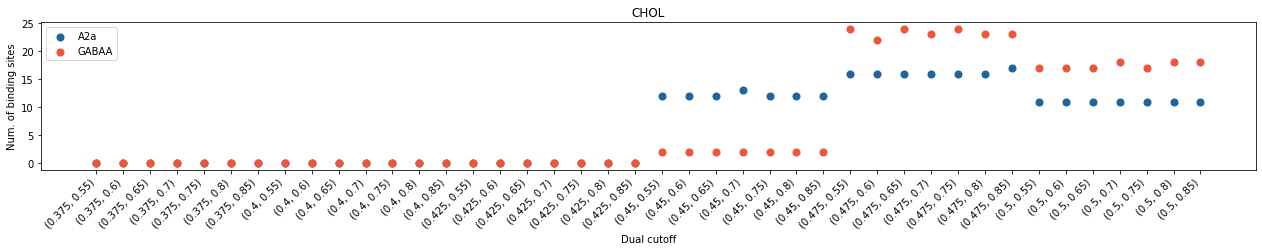

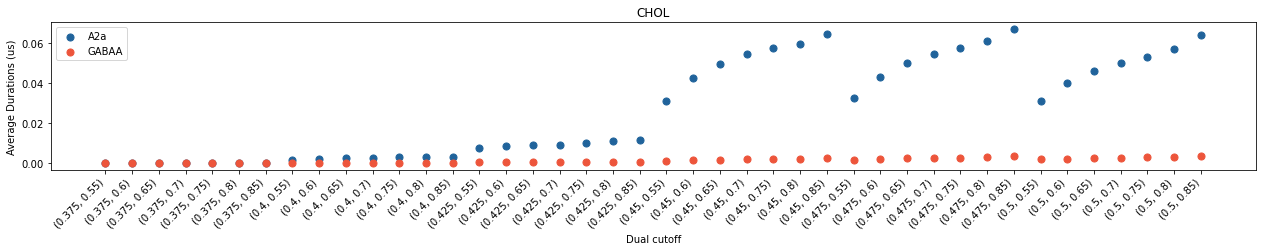

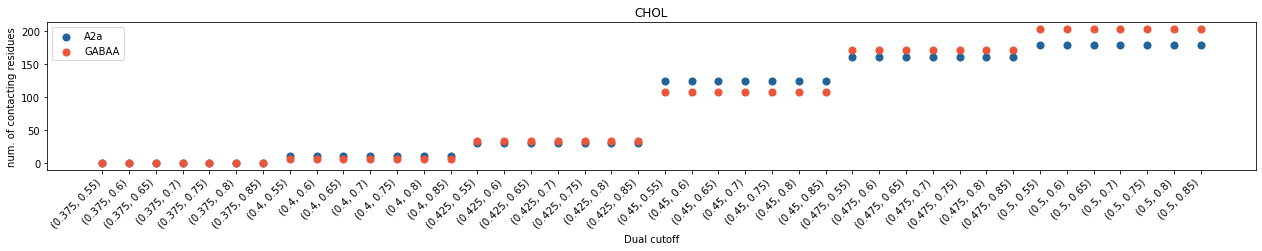

In [22]:
import matplotlib.pyplot as plt

def graph_compare(cutoff_list, data1, data2, label1, label2, ylabel, title, fn):
    colors = ["#20639B", "#ED553B"]
    fig, ax = plt.subplots(1, 1, figsize=(len(cutoff_list)*0.42, 3.6))
    m1 = ax.scatter(np.arange(len(cutoff_list)), data1, s=50, color=colors[0])
    m2 = ax.scatter(np.arange(len(cutoff_list)), data2, s=50, color=colors[1])
    ax.set_xticks(np.arange(len(cutoff_list)))
    ax.set_xticklabels(cutoff_list, rotation=45, ha='right')
    ax.set_xlabel("Dual cutoff")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend([m1, m2], [label1, label2], loc="upper left")
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    return


lipid = "CHOL"
with open(f"./test_cutoffs_A2a/test_cutoff_data_{lipid}.pickle", "rb") as f:
    data_A2a = pickle.load(f)
with open(f"./test_cutoffs_GABAA/test_cutoff_data_{lipid}.pickle", "rb") as f:
    data_GABAA = pickle.load(f)
    
if data_A2a["test_cutoff_list"] == data_GABAA["test_cutoff_list"]:
    # plot 1 
    graph_compare(data_A2a["test_cutoff_list"], data_A2a["num_of_binding_sites"], 
                  data_GABAA["num_of_binding_sites"], "A2a", "GABAA", "Num. of binding sites",
                 lipid, f"cmp_num_of_bs_{lipid}.png")

    # plot 2
    graph_compare(data_A2a["test_cutoff_list"], data_A2a["duration_avgs"], 
                 data_GABAA["duration_avgs"], "A2a", "GABAA", f"Average Durations ({timeunit})",
                 lipid, f"cmp_durations_{lipid}.png")

    # plot 3
    graph_compare(data_A2a["test_cutoff_list"], data_A2a["num_of_contacting_residues"],
                 data_GABAA["num_of_contacting_residues"], "A2a", "GABAA", "num. of contacting residues",
                 lipid, f"cmp_num_of_contacting_residues_{lipid}.png")
